# Evaluate marker selection method with scRNA-seq data

In this notebook the goal is to assess the cell type classification accuracy that can be obtained with the selected markers. Because the transcriptomic information of each cell is not totally summarize be the markers and also because the cell type annotation can be fuzzy, we do not expect the cell type calling accuracy to be 100% 
Of note, if the scRNA-seq data use are not normalized, the  cell type calling accuracy obtain with this notebook will be the  cell type calling accuracy obtain in the FISH experiement if the RNA-cell association (cell segmentation) is perfect.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import pandas as pd
import numpy as np
import scanpy as sc


import numpy as np
import pandas as pd
import scanpy as sc
from sklearn import metrics
from tqdm import tqdm

## test list accuracy


**HANDCRAFTED LIST BASELINE**

In [3]:

### gene list from ns-forest
list_gene = ['Atp6v0d2', 'Abcg1',  # AM
                           'Rtkn2', 'Igfbp2',  # AT1
                           'Sftpc', 'Cxcl15',  # AT2,
                           'Cd79a',  # B_cells
                           'Ms4a2', 'Fcer1a',  # Basophils
                           'Ccdc153',  # Ciliated
                           'Scgb3a2', 'Scgb1a1',  # Club
                           'Cst3',  # DC
                           'Cdh5', 'Clec14a',  # EC
                           'Inmt', 'Pcolce2',  # Fibroblasts
                           'C1qc', 'C1qa', 'C1qb',  # 'C3ar1', #IM
                           'Upk3b',  # Mesotheliocytes
                           'Ifitm6', 'Plac8',  # Monocytes
                           'Ms4a4b', 'Ccl5', 'Hcst',  # NK_T_cells
                           'Gzma', 'Ncr1',  # NK_cells
                           'S100a9',  # Neutrophils
                           'Mmrn1',  # Platelets
                           'Acta2', 'Myh11',  # SMC
                           'Cd3g', 'Cd3d'  # T_cells
                           ]  # 


**SET parameter** anndata, cell types, list_gene


In [5]:
## set anndata
anndata_raw = sc.read(
    "./test_set/test_anndata.h5ad")
anndata_raw.X = anndata_raw.X.toarray()
anndata_raw = anndata_raw[:, list_gene]

## set column to target: phase, cell type ...
key_target = 'cell_ID'

### to run classifiaction with cosine distance with the previous parameter


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:01<00:00, 2370.51it/s]


Accuracy 0.809


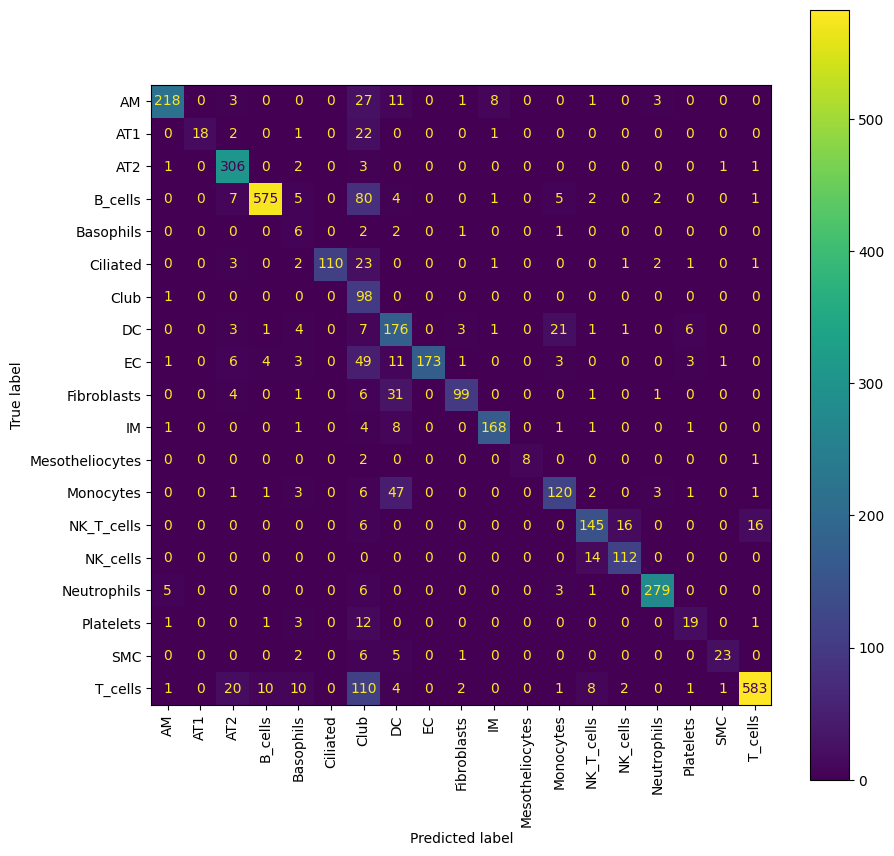

In [12]:
### to run with the previous parameter
y_true = np.array(anndata_raw.obs[key_target])

scrna_unique_clusters = np.unique(anndata_raw.obs[key_target])

scrna_centroids = []

for i in range(len(scrna_unique_clusters)):
    scrna_centroids.append(np.mean(anndata_raw[
                    anndata_raw.obs[key_target] == scrna_unique_clusters[i]].X, axis=0))

y_pred = []
from tqdm import tqdm
for index_cell  in tqdm(range(anndata_raw.shape[0])):
    rna_seq = anndata_raw.X[index_cell]
    norm_expression_vectors = np.array([rna_seq])
    correlation_array = metrics.pairwise.cosine_similarity(norm_expression_vectors,
                                                           np.array(scrna_centroids))[0]
    index_cluster_max = np.argmax(correlation_array)
    pred_rna_seq = scrna_unique_clusters[index_cluster_max]
    y_pred.append(pred_rna_seq)




print(f"Accuracy {metrics.accuracy_score(y_true, y_pred)}")
cm = metrics.confusion_matrix(y_true, y_pred)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred, labels=scrna_unique_clusters)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=scrna_unique_clusters)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation = "vertical")

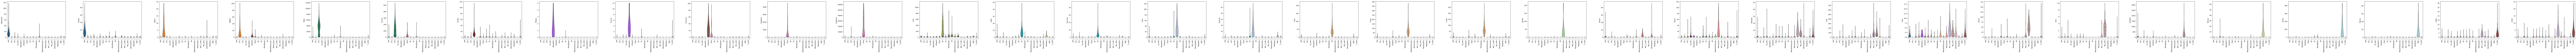

In [7]:
import warnings
warnings.filterwarnings("ignore")
sc.pl.violin(anndata_raw, keys=list_gene, groupby='cell_ID',
             rotation=90, save='violin_phase.pdf',   use_raw=False)
